In [2]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import string
from matplotlib import gridspec
import scipy as sp

import time
import pickle
import re

import urllib.request
from bs4 import BeautifulSoup

import memory_profiler

%load_ext memory_profiler

from pathlib import Path

In [3]:
mpl.__version__

'3.6.2'

In [4]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [5]:
%load_ext autoreload
%autoreload 2

from pubmed_landscape_src.plotting import *
from pubmed_landscape_src.exploration import (
    find_mask_words,
    print_tfidf_top_words,
    print_tfidf_threshold_words,
)

In [6]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")

In [7]:
plt.style.use("matplotlib_style.txt")

# Import

In [8]:
# import clean_df_updated
clean_df_updated_reparsed_filtered = pd.read_pickle(
    berenslab_data_path
    / "clean_df_updated_reparsed_filtered_with_authors_ISSN"
)

tcmalloc: large alloc 1073741824 bytes == 0x8b6fb8000 @ 
tcmalloc: large alloc 1233903616 bytes == 0x960f38000 @ 
tcmalloc: large alloc 2147483648 bytes == 0x9aaff6000 @ 
tcmalloc: large alloc 1542381568 bytes == 0x8f70b8000 @ 
tcmalloc: large alloc 1927979008 bytes == 0xa2aff6000 @ 


In [9]:
pmids_dataset = clean_df_updated_reparsed_filtered.PMID.to_numpy()

In [10]:
all_abstracts = clean_df_updated_reparsed_filtered.AbstractText

In [11]:
tsne_reparsed = np.load(variables_path / "tsne_reparsed.npy")

In [12]:
tsne = np.vstack((-tsne_reparsed[:, 0], tsne_reparsed[:, 1])).T

In [13]:
mask_retracted_pmids = np.load(variables_path / "mask_retracted_pmids.npy")

# Retracted papers

## Scrape PMIDs 

In [239]:
%%time
retracted_pmids_desc = []

for page in range(1, 50):
    page = str(page)
    size = str(200)
    url = (
        "https://pubmed.ncbi.nlm.nih.gov/?size="
        + size
        + "&page="
        + page
        + "&term=%22Retracted+Publication%22[pt]&sort=date&sort_order=desc&format=pmid"
    )
    urllib.request.urlretrieve(url, "pmids.txt")

    with open("pmids.txt") as f:
        contents = f.read()
        soup = BeautifulSoup(contents, "html.parser")
        retracted_pmids_desc.append(soup.get_text().split()[7:])

retracted_pmids_desc = np.hstack(retracted_pmids_desc)

CPU times: user 831 ms, sys: 68 ms, total: 899 ms
Wall time: 44.9 s


In [17]:
np.save(variables_path / "retracted_pmids_desc", retracted_pmids_desc)

In [240]:
%%time
retracted_pmids_asc = []

for page in range(1, 21):
    page = str(page)
    size = str(200)
    url = (
        "https://pubmed.ncbi.nlm.nih.gov/?size="
        + size
        + "&page="
        + page
        + "&term=%22Retracted+Publication%22[pt]&sort=date&sort_order=asc&format=pmid"
    )
    urllib.request.urlretrieve(url, "pmids.txt")

    with open("pmids.txt") as f:
        contents = f.read()
        soup = BeautifulSoup(contents, "html.parser")
        retracted_pmids_asc.append(soup.get_text().split()[7:])

retracted_pmids_asc = np.hstack(retracted_pmids_asc)

CPU times: user 333 ms, sys: 29 ms, total: 362 ms
Wall time: 18 s


In [19]:
np.save(variables_path / "retracted_pmids_asc", retracted_pmids_asc)

In [241]:
retracted_pmids_asc = np.load(variables_path / "retracted_pmids_asc.npy")
retracted_pmids_desc = np.load(variables_path / "retracted_pmids_desc.npy")

In [218]:
retracted_pmids = np.unique(
    np.hstack((retracted_pmids_desc, retracted_pmids_asc))
)
retracted_pmids.shape

(13569,)

In [224]:
np.save(variables_path / "retracted_pmids", retracted_pmids)

## Mask

In [251]:
%%time
dict_map = dict()
for elem in retracted_pmids:
    dict_map[elem] = 1

CPU times: user 5.07 ms, sys: 1 ms, total: 6.07 ms
Wall time: 6.05 ms


In [252]:
%%time
pre_mask = np.vectorize(dict_map.get)(pmids_dataset)

CPU times: user 1.28 s, sys: 915 µs, total: 1.28 s
Wall time: 1.28 s


In [253]:
%%time
pre_mask = np.where(pre_mask == None, 0, pre_mask)
pre_mask = np.where(pre_mask == "None", 0, pre_mask)

CPU times: user 968 ms, sys: 23 µs, total: 968 ms
Wall time: 968 ms


In [254]:
mask_retracted_pmids = pre_mask == 1

In [255]:
np.save(variables_path / "mask_retracted_pmids", mask_retracted_pmids)

## Mentions in the abstract
We extract the papers that mention the following words ("retracted", "retraction", "withdrawal") in the abstract to exclude them from the plot. We want to highlight only retracted papers that do not explicitly state in their abstract that they have been retracted.

In [14]:
abstracts = all_abstracts[mask_retracted_pmids]

In [15]:
word = "retracted"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retracted = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retracted)[0]),
)

Number of papers with uncapitalized word ' retracted':  160
Number of papers with capitalized word 'Retracted':  10
Number of papers with uppercased word 'RETRACTED':  0
Number of total papers with retracted:  160


In [16]:
word = "retraction"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_retraction = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    len(np.where(indexes2 != -1)[0]),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_retraction)[0]),
)

Number of papers with uncapitalized word ' retraction':  42
Number of papers with capitalized word 'Retraction':  12
Number of papers with uppercased word 'RETRACTION':  0
Number of total papers with retraction:  46


In [17]:
word = "withdrawal"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawal = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawal)[0]),
)

Number of papers with uncapitalized word ' withdrawal':  43
Number of papers with capitalized word 'Withdrawal':  146
Number of papers with uppercased word 'WITHDRAWAL':  0
Number of total papers with withdrawal:  187


In [18]:
word = "withdrawn"
sub1 = " " + word
sub2 = word.capitalize()
sub3 = word.upper()

indexes1 = abstracts.str.find(sub1)
indexes2 = abstracts.str.find(sub2)
indexes3 = abstracts.str.find(sub3)

mask_withdrawn = (indexes1 != -1) | (indexes2 != -1) | (indexes3 != -1)


print(
    f"Number of papers with uncapitalized word '{sub1}': ",
    len(np.where(indexes1 != -1)[0]),
)
print(
    f"Number of papers with capitalized word '{sub2}': ",
    np.sum(indexes2 != -1),
)
print(
    f"Number of papers with uppercased word '{sub3}': ",
    len(np.where(indexes3 != -1)[0]),
)
print(
    f"Number of total papers with {word}: ",
    len(np.where(mask_withdrawn)[0]),
)

Number of papers with uncapitalized word ' withdrawn':  34
Number of papers with capitalized word 'Withdrawn':  0
Number of papers with uppercased word 'WITHDRAWN':  0
Number of total papers with withdrawn:  34


In [19]:
print(
    f"There are {np.sum((~mask_retraction)& (~mask_retracted)& (~mask_withdrawal)& (~mask_withdrawn))} intact papers"
)

There are 11756 intact papers


## Intact PMIDs

In [45]:
intact_retracted_pmids = pmids_dataset[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]
print(intact_retracted_pmids.shape)
np.save(variables_path / "intact_retracted_pmids", intact_retracted_pmids)

(11756,)


# Plot

(-220.0, 220.0, -220.0, 220.0)

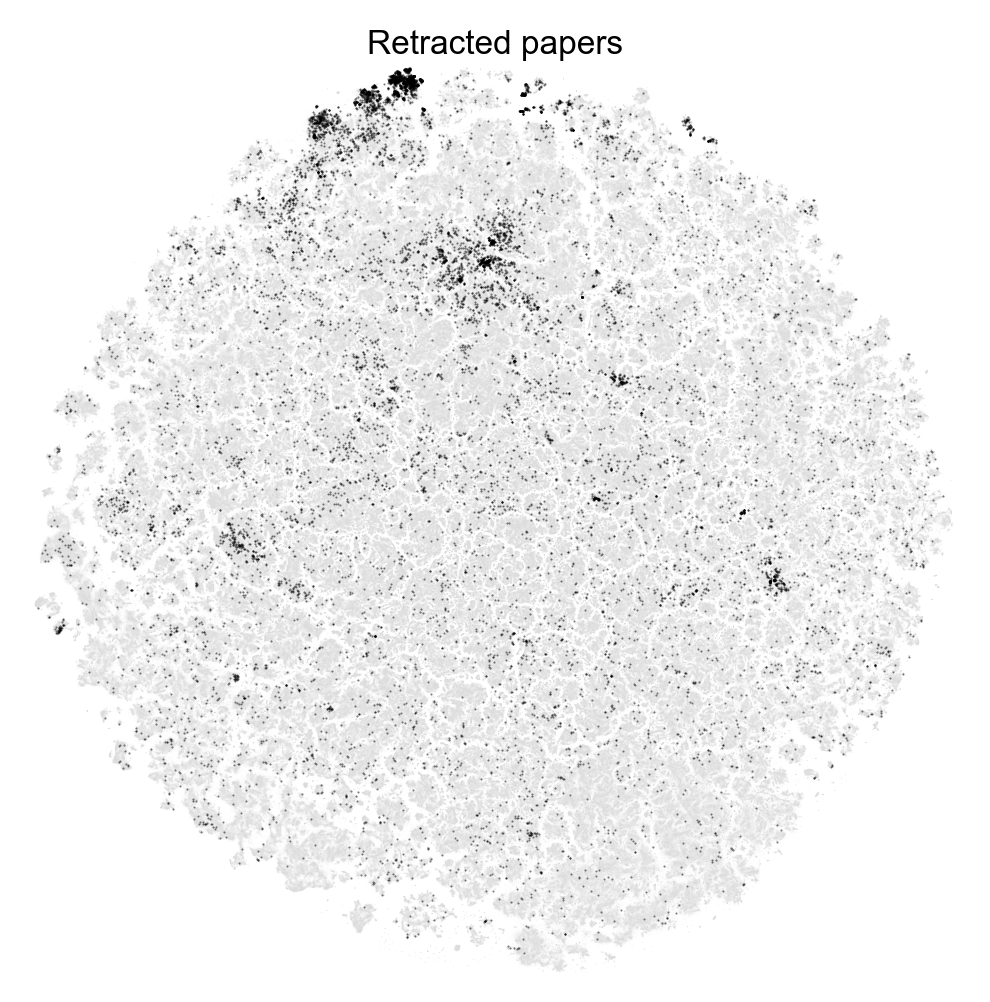

In [19]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

# subplot b
x_lim = (-220, 220)
y_lim = (-220, 220)

s_grey = 0.5
alpha_grey = 0.02
s_color = 1
alpha_color = 0.5

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

ax.scatter(
    tsne[:, 0],
    tsne[:, 1],
    c="lightgrey",
    s=s_grey,
    alpha=alpha_grey,
    marker=".",
    linewidths=0,
    rasterized=True,
    ec="None",
)

ax.scatter(
    *subregion.T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    linewidths=0,
    rasterized=True,
)


ax.set_title("Retracted papers")
ax.axis("equal")
ax.set_xlim(x_lim[0], x_lim[1])
ax.set_ylim(y_lim[0], y_lim[1])
ax.axis("off")

## First inset

In [21]:
mpl.rcParams["axes.spines.right"] = True
mpl.rcParams["axes.spines.top"] = True
mpl.rcParams["axes.linewidth"] = 0.5

(200.0, 220.0)

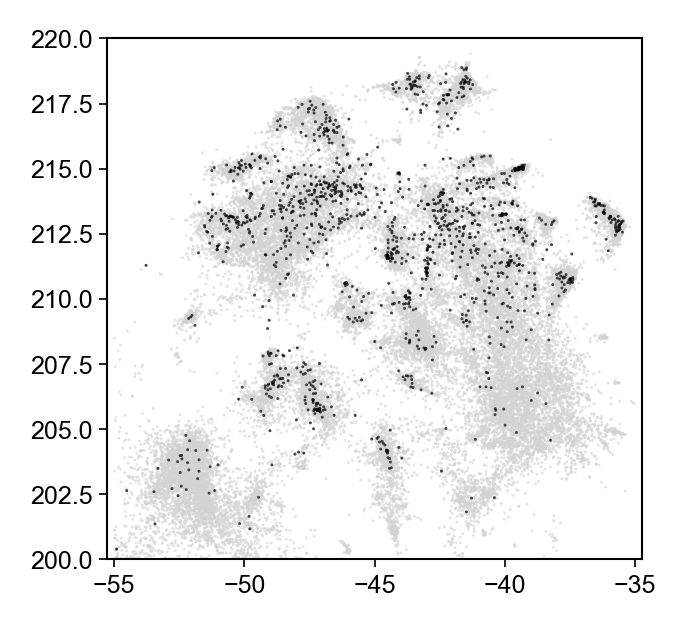

In [22]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(2.3, 2.3), dpi=300)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

right = -35
left = -55
top = 220
bottom = 200

# manually
s_grey = 2
s_color = 2
alpha_grey = 0.6
alpha_color = 0.7

mask_grey = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

ax1.scatter(
    *tsne[mask_grey].T,
    s=s_grey,
    c="lightgrey",
    alpha=alpha_grey,
    marker=".",
    ec="None",
    rasterized=True,
)

mask_retracted_zoom = (
    (subregion[:, 0] < right)
    & (subregion[:, 0] > left)
    & (subregion[:, 1] < top)
    & (subregion[:, 1] > bottom)
)
ax1.scatter(
    *subregion[mask_retracted_zoom].T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax1.axis("equal")
ax1.set_xlim(left, right)
ax1.set_ylim(bottom, top)
# ax1.set_xticks([])
# ax1.set_yticks([])

In [ ]:
# mask island 1
right = -35
left = -55
top = 220
bottom = 200
mask_zoom_region = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)
print(f"There are {np.sum(mask_zoom_region)} papers in the zoom")

mask_zoom_region_non_retracted = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
    & (~mask_retracted_pmids)
)
print(
    f"There are {np.sum(mask_zoom_region_non_retracted)} non-retracted papers in the zoom"
)
print(
    "Number of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted)),
)
print(
    "Fraction of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted))
    / np.sum(mask_zoom_region)
    * 100,
)

There are 38252 papers in the zoom
There are 36899 non-retracted papers in the zoom
Number of retracted papers:  1353
Fraction of retracted papers:  3.537069957126425


## Second inset

(214.0, 216.0)

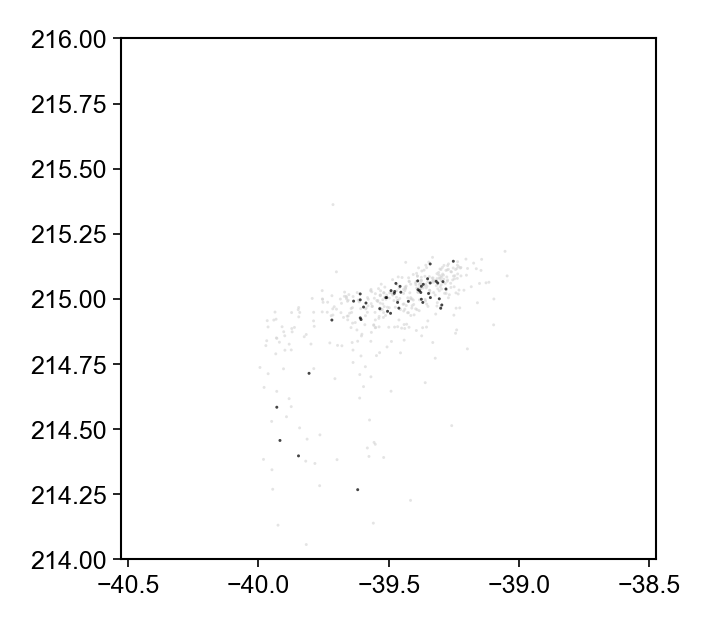

In [23]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(2.3, 2.3), dpi=300)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

right = -39
left = -40
top = 216
bottom = 214

# manually
s_grey = 2
s_color = 2
alpha_grey = 0.6
alpha_color = 0.7

mask_grey = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

ax1.scatter(
    *tsne[mask_grey].T,
    s=s_grey,
    c="lightgrey",
    alpha=alpha_grey,
    marker=".",
    ec="None",
    rasterized=True,
)

mask_retracted_zoom = (
    (subregion[:, 0] < right)
    & (subregion[:, 0] > left)
    & (subregion[:, 1] < top)
    & (subregion[:, 1] > bottom)
)
ax1.scatter(
    *subregion[mask_retracted_zoom].T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax1.axis("equal")
ax1.set_xlim(left, right)
ax1.set_ylim(bottom, top)
# ax1.set_xticks([])
# ax1.set_yticks([])
# ax1.grid()

### Select 25 random non-retracted papers

In [98]:
# mask island 1
right = -39
left = -40
top = 216
bottom = 214
mask_zoom_region = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)
print(f"There are {np.sum(mask_zoom_region)} papers in the zoom")

mask_zoom_region_non_retracted = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
    & (~mask_retracted_pmids)
)
print(
    f"There are {np.sum(mask_zoom_region_non_retracted)} non-retracted papers in the zoom"
)
print(
    "Number of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted)),
)
print(
    "Fraction of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted))
    / np.sum(mask_zoom_region)
    * 100,
)

There are 443 papers in the zoom
There are 395 non-retracted papers in the zoom
Number of retracted papers:  48
Fraction of retracted papers:  10.835214446952596


In [71]:
np.random.seed(42)
subset = np.random.choice(
    np.sum(mask_zoom_region_non_retracted), size=25, replace=False
)

In [72]:
clean_df_updated_reparsed_filtered[mask_zoom_region_non_retracted].iloc[subset]

,PMID,Title,AbstractText,Language,Journal,Date,NameFirstAuthor,NameLastAuthor,ISSN,filename
3733096,29614499,MicroRNA-330-3p Expression Indicates Good Prog...,Growing evidence has shown that miR-330-3p is ...,eng,Cellular physiology and biochemistry : interna...,2018,Zhenxin,Xiangfeng,1421-9778,pubmed21n0942.xml
19416874,33552270,miR-128-3p serves as an oncogenic microRNA in ...,Osteosarcoma is the second leading cause of ca...,eng,Oncology letters,2021 Feb,Maoshu,Xinjiang,1792-1074,pubmed22n1070.xml
12768288,28117029,MicroRNA-148a Acts as a Tumor Suppressor in Os...,MicroRNAs (miRs) have been demonstrated to be ...,eng,Oncology research,2017 Sep 21,HaiYan,XiaoHua,1555-3906,pubmed21n0894.xml
2981042,30988764,miR-552-5p facilitates osteosarcoma cell proli...,miR-552 promotes tumor growth and metastasis i...,eng,Experimental and therapeutic medicine,2019 May,Wei,Zhen,1792-0981,pubmed21n0987.xml
20545689,33884030,Downregulation of miR-588 is associated with t...,Osteosarcoma (OS) is a primary malignant tumor...,eng,Experimental and therapeutic medicine,2021 Jun,Tao,Weidong,1792-0981,pubmed22n1081.xml
11551649,30546411,MicroRNA-466 inhibits osteosarcoma cell prolif...,Emerging pieces of evidence indicate that micr...,eng,Experimental and therapeutic medicine,2018 Dec,Wei,Tiejun,1792-0981,pubmed21n0972.xml
2296165,25322765,MiR-23a functions as a tumor suppressor in ost...,Osteosarcoma is the most common primary bone m...,eng,Cellular physiology and biochemistry : interna...,2014,Yu,Shuhua,1421-9778,pubmed21n0809.xml
12227165,31949613,miR-761 inhibits human osteosarcoma progressio...,microRNAs (miRs) are endogenous noncoding RNAs...,eng,International journal of clinical and experime...,2018,Shaoyun,Suwei,1936-2625,pubmed21n1018.xml
16726707,23507142,miR-16 inhibits cell proliferation by targetin...,Several miRNAs have been implicated in the dev...,eng,FEBS letters,2013 May 02,Lei,Xian-hua,1873-3468,pubmed21n0753.xml
5750666,30574019,miRNA-133b targets FGFR1 and presents multiple...,Osteosarcoma (OS) is the most common bone mali...,eng,Cancer cell international,2018,Gan,Xun-Yan,1475-2867,pubmed21n0973.xml


In [73]:
clean_df_updated_reparsed_filtered[mask_zoom_region_non_retracted].iloc[
    subset
].PMID

3733096     29614499
19416874    33552270
12768288    28117029
2981042     30988764
20545689    33884030
11551649    30546411
2296165     25322765
12227165    31949613
16726707    23507142
5750666     30574019
315404      26855583
10971378    26243299
17181842    30721745
20682356    34476004
13212793    32709240
7500477     30277613
6285476     25385479
14108906    29725464
17194142    30737029
17674269    24762226
688025      26018508
20547709    33886809
8118044     27624383
13253       22457788
7022455     26341146
Name: PMID, dtype: object

In [75]:
# Print titles. All of them follow the pattern:
# X does Y by targeting / directly targeting Z"
# MicroRNA-X does Y (by targeting Z) in osteosarcoma"

for elem in (
    clean_df_updated_reparsed_filtered[mask_zoom_region_non_retracted]
    .iloc[subset]
    .Title.to_list()
):
    print(elem)
    print("-----------------------------------")

MicroRNA-330-3p Expression Indicates Good Prognosis and Suppresses Cell Proliferation by Targeting Bmi-1 in Osteosarcoma.
-----------------------------------
miR-128-3p serves as an oncogenic microRNA in osteosarcoma cells by downregulating ZC3H12D.
-----------------------------------
MicroRNA-148a Acts as a Tumor Suppressor in Osteosarcoma via Targeting Rho-Associated Coiled-Coil Kinase.
-----------------------------------
miR-552-5p facilitates osteosarcoma cell proliferation and metastasis by targeting WIF1.
-----------------------------------
Downregulation of miR-588 is associated with tumor progression and unfavorable prognosis in patients with osteosarcoma.
-----------------------------------
MicroRNA-466 inhibits osteosarcoma cell proliferation and induces apoptosis by targeting CCND1.
-----------------------------------
MiR-23a functions as a tumor suppressor in osteosarcoma.
-----------------------------------
miR-761 inhibits human osteosarcoma progression by targeting CXCR1

## Baseline
Another region from the area with high concentration of retracted papers (inset 1), but this one with a lower fraction of retracted papers (No retracted papers). Chosen for comparison.

(200.0, 203.0)

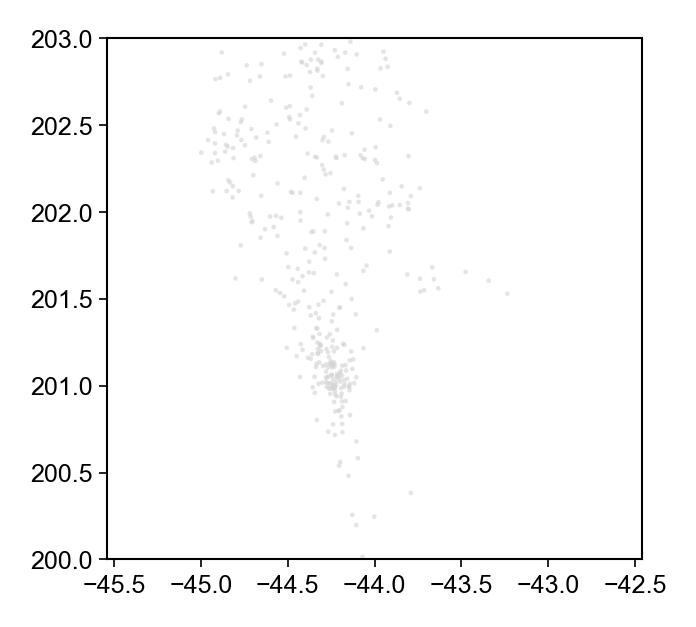

In [26]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(2.3, 2.3), dpi=300)

txtkwargs = dict(size=8, weight="bold", va="top", ha="left")

subregion = tsne[mask_retracted_pmids][
    (~mask_retraction)
    & (~mask_retracted)
    & (~mask_withdrawal)
    & (~mask_withdrawn)
]

right = -43
left = -45
top = 203
bottom = 200

# manually
s_grey = 5
s_color = 5
alpha_grey = 0.6
alpha_color = 0.7

mask_grey = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)

ax1.scatter(
    *tsne[mask_grey].T,
    s=s_grey,
    c="lightgrey",
    alpha=alpha_grey,
    marker=".",
    ec="None",
    rasterized=True,
)

mask_retracted_zoom = (
    (subregion[:, 0] < right)
    & (subregion[:, 0] > left)
    & (subregion[:, 1] < top)
    & (subregion[:, 1] > bottom)
)
ax1.scatter(
    *subregion[mask_retracted_zoom].T,
    s=s_color,
    c="black",
    alpha=alpha_color,
    marker=".",
    ec="None",
    rasterized=True,
)

ax1.axis("equal")
ax1.set_xlim(left, right)
ax1.set_ylim(bottom, top)
# ax1.set_xticks([])
# ax1.set_yticks([])
# ax1.grid()

### Select 25 random non-retracted papers

In [27]:
# mask island 1
right = -43
left = -45
top = 203
bottom = 200
mask_zoom_region = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
)
print(f"There are {np.sum(mask_zoom_region)} papers in the zoom")

mask_zoom_region_non_retracted = (
    (tsne[:, 0] < right)
    & (tsne[:, 0] > left)
    & (tsne[:, 1] < top)
    & (tsne[:, 1] > bottom)
    & (~mask_retracted_pmids)
)
print(
    f"There are {np.sum(mask_zoom_region_non_retracted)} non-retracted papers in the zoom"
)
print(
    "Number of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted)),
)
print(
    "Fraction of retracted papers: ",
    (np.sum(mask_zoom_region) - np.sum(mask_zoom_region_non_retracted))
    / np.sum(mask_zoom_region)
    * 100,
)

There are 361 papers in the zoom
There are 361 non-retracted papers in the zoom
Number of retracted papers:  0
Fraction of retracted papers:  0.0


In [80]:
np.random.seed(42)
subset = np.random.choice(
    np.sum(mask_zoom_region_non_retracted), size=25, replace=False
)

In [81]:
clean_df_updated_reparsed_filtered[mask_zoom_region_non_retracted].iloc[subset]

,PMID,Title,AbstractText,Language,Journal,Date,NameFirstAuthor,NameLastAuthor,ISSN,filename
10038998,25206959,"Proteome analysis of multidrug-resistant, brea...",Cancer multidrug resistance (MDR) occurs when ...,eng,Journal of extracellular vesicles,2014,Deep,Mary,2001-3078,pubmed21n0806.xml
2302083,25330373,Deep sequencing of RNA from three different ex...,Secreted microRNAs (miRNAs) enclosed within ex...,eng,PloS one,2014,Hong,Richard J,1932-6203,pubmed21n0809.xml
1284847,27152724,Epidermal Growth Factor Receptor in Prostate C...,Exosomes proteins and microRNAs have gained mu...,eng,PloS one,2016,Geetanjali,Emma S,1932-6203,pubmed21n0867.xml
19831585,34060205,Lysine demethylase LSD1 delivered via small ex...,Several studies have examined the functions of...,eng,EMBO reports,2021 08 04,Li-Juan,Hong-Min,1469-3178,pubmed22n1087.xml
3719920,30393102,Therapeutic Targeting Cancer-Initiating Cell M...,Transfer of exosomes (Exo) miRNA was described...,eng,Translational oncology,2019 Feb,Daisuke,Margot,1936-5233,pubmed21n0967.xml
11480068,31696667,Upregulation of E-cadherin in bronchoalveolar ...,Lung cancer features extremely high rates of m...,eng,Thoracic cancer,2020 01,Ying,Lingyun,1759-7714,pubmed21n1010.xml
4900967,29306323,Mechanism of recipient cell-dependent differen...,"Exosomes, small-membrane vesicles, are secrete...",eng,BMC cancer,2018 01 06,Sayo,Yoshiyuki,1471-2407,pubmed21n0932.xml
7226928,27941677,The Enrichment of Survivin in Exosomes from Br...,The generation and release of membrane-enclose...,eng,Cancers,2016 Dec 09,Bridget T,Marc A,2072-6694,pubmed21n0890.xml
16870982,25819770,Papillary thyroid cancer-derived exosomes cont...,With the increasing diagnosis of indolent papi...,eng,The Journal of surgical research,2015 Jun 01,James C,Stan,1095-8673,pubmed21n0825.xml
7613616,26675257,Exosomes from bulk and stem cells from human p...,The different prostate cancer (PCa) cell popul...,eng,Oncotarget,2016 Jan 26,Catherine A,Juan C,1949-2553,pubmed21n0852.xml


In [82]:
# Print titles
# One can see much more variation in title style and structure despite them being about similar topic.
for elem in (
    clean_df_updated_reparsed_filtered[mask_zoom_region_non_retracted]
    .iloc[subset]
    .Title.to_list()
):
    print(elem)
    print("-----------------------------------")

Proteome analysis of multidrug-resistant, breast cancer-derived microparticles.
-----------------------------------
Deep sequencing of RNA from three different extracellular vesicle (EV) subtypes released from the human LIM1863 colon cancer cell line uncovers distinct miRNA-enrichment signatures.
-----------------------------------
Epidermal Growth Factor Receptor in Prostate Cancer Derived Exosomes.
-----------------------------------
Lysine demethylase LSD1 delivered via small extracellular vesicles promotes gastric cancer cell stemness.
-----------------------------------
Therapeutic Targeting Cancer-Initiating Cell Markers by Exosome miRNA: Efficacy and Functional Consequences Exemplified for claudin7 and EpCAM.
-----------------------------------
Upregulation of E-cadherin in bronchoalveolar lavage fluid-derived exosomes in patients with lung cancer.
-----------------------------------
Mechanism of recipient cell-dependent differences in exosome uptake.
---------------------------